In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

Reading in mutation/generation time estimates from Kuderna. I will assume that chromosome X has 80 % of the mutation rate of autosomes, corresponding to a 4:1 male bias in mutations.

In [49]:
# Mutation rate percentage calc.
(3*1/3+1*2/3)/(3*1/2+1*1/2)

# Even if females have no mutations, it's only 2/3
# (4*1/3+0*2/3)/(4*1/2+0*1/2)

0.8333333333333333

In [50]:
0.75*0.8333333333333333

0.625

In [3]:
kuderna_data = pd.read_csv("../data/science.abn7829_data_s2.csv")

In [4]:
# I pick out the following columns
col_species_mut = ['SPECIES_BINOMIAL', 'GENUS', 'SPECIES', 'FAMILY', 'GENERATION_LENGTH', 'MU_PER_GENERATION',
       'MU_PER_YEAR', 'EFFECTIVE_POP_SIZE']
df_species_mut = kuderna_data[col_species_mut]

<Axes: xlabel='MU_PER_YEAR', ylabel='Count'>

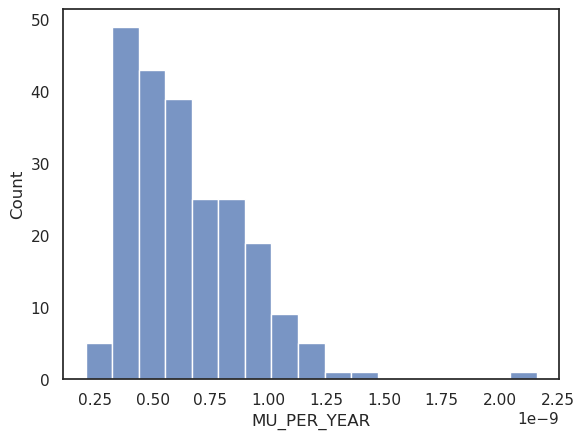

In [5]:
sns.histplot(kuderna_data[col_species_mut].MU_PER_YEAR)

<Axes: xlabel='GENERATION_LENGTH', ylabel='Count'>

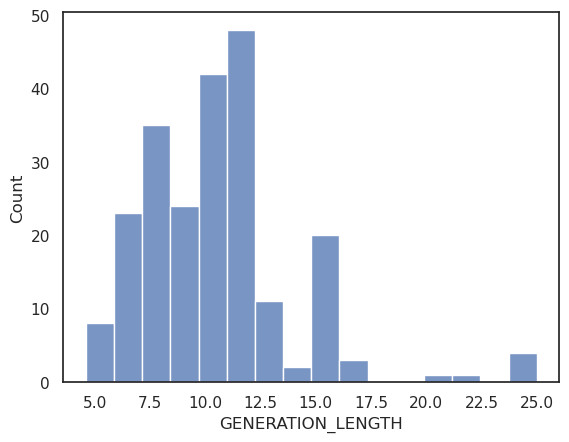

In [6]:
sns.histplot(kuderna_data[col_species_mut].GENERATION_LENGTH)

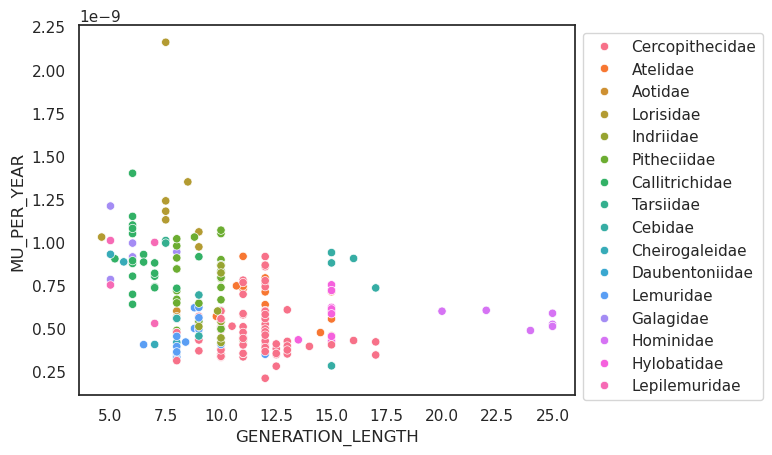

In [7]:
g = sns.scatterplot(data=kuderna_data, x="GENERATION_LENGTH", y="MU_PER_YEAR", hue="FAMILY")
plt.legend(bbox_to_anchor=(1.0, 1))

In [8]:
metadata_dir = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"


metadata_dirs = glob.glob(metadata_dir+"*_individuals.txt")

df_l = []
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    df_l.append(dir_metadata)
all_inds = pd.concat(df_l)

In [9]:
all_inds.loc[all_inds.GVCF_ID == "PD_0629"]

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,SUBSPECIES,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y
0,SAMEA112483158,PD_0629,PD_0629,ERS14600509,PRJEB59576,Carlito_syrichta_ssp,Carlito_syrichta_ssp,Cephalopachus_bancanus_ssp,Carlito,syrichta,ssp,Unknown,Unknown,26.723,0.979,Unknown,Unknown,Unknown,Unknown


In [10]:
df_species_mut.loc[df_species_mut.GENUS == "Carlito"]

,SPECIES_BINOMIAL,GENUS,SPECIES,FAMILY,GENERATION_LENGTH,MU_PER_GENERATION,MU_PER_YEAR,EFFECTIVE_POP_SIZE
32,Carlito_syrichta,Carlito,syrichta,Tarsiidae,7.5,7.580000e-09,1.010000e-09,74616


In [41]:
c_list = []
for p in glob.glob("../steps/cobraa/*"):
    if len(glob.glob(p+"/*final_parameters.txt")) >= 1:
        c_list.append(glob.glob(p+"/*final_parameters.txt")[0])
c_list

['../steps/cobraa/PD_0346/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0156/HiC_scaffold_1_final_parameters.txt',
 '../steps/cobraa/PD_0121/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0119/CM063169.1_final_parameters.txt',
 '../steps/cobraa/SAMN23530509/NC_044976.1_final_parameters.txt',
 '../steps/cobraa/PD_0009/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0351/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0122/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0629/JAPVLO010000001.1_final_parameters.txt',
 '../steps/cobraa/PD_0174/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0120/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0522/CM104434.1_final_parameters.txt',
 '../steps/cobraa/SAMN23530506/HiC_scaffold_1_final_parameters.txt',
 '../steps/cobraa/SAMN43386187/CM104434.1_final_parameters.txt']

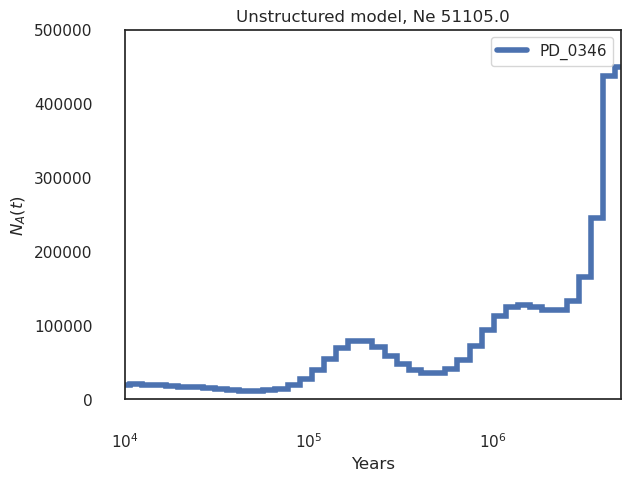

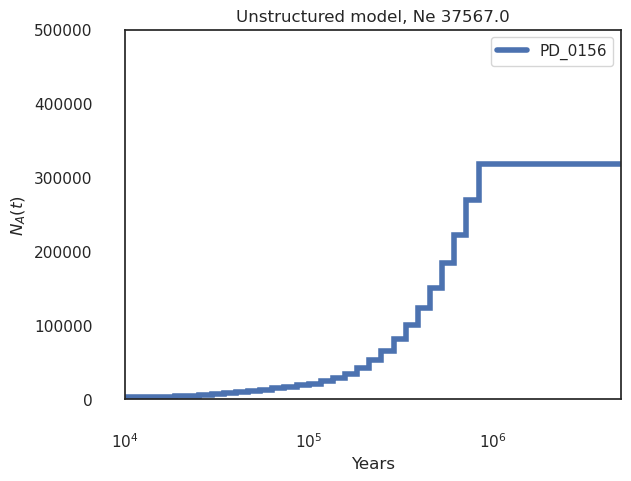

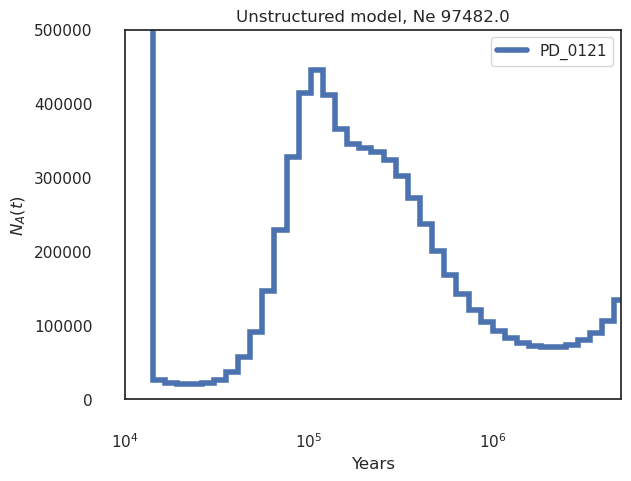

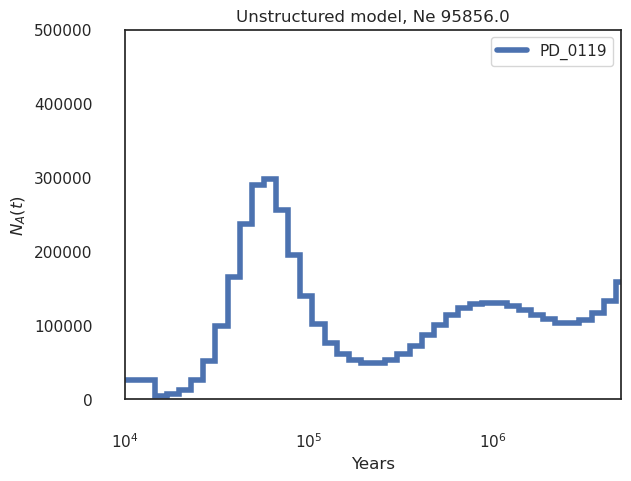

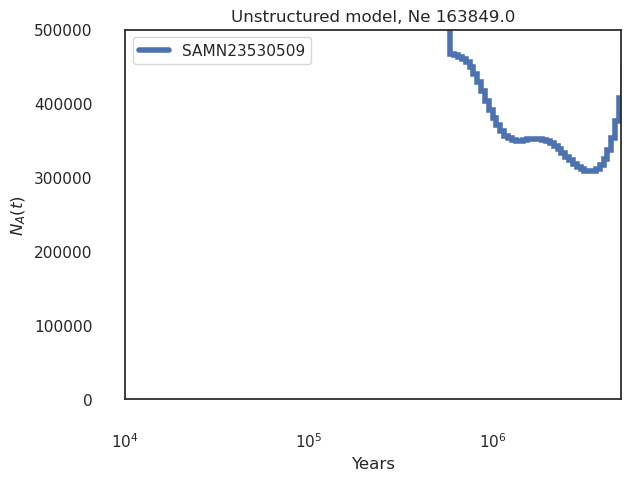

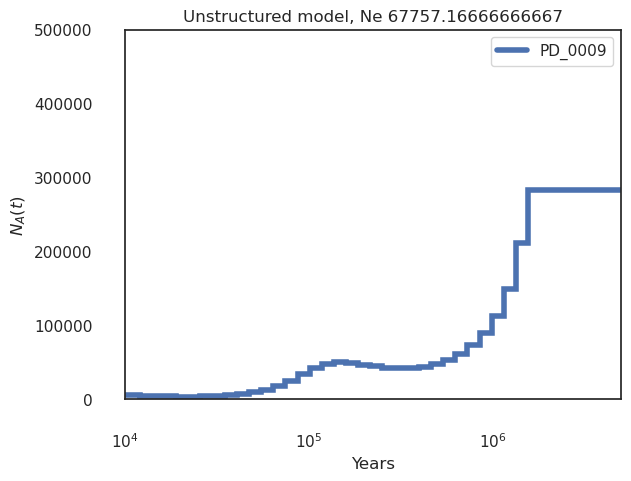

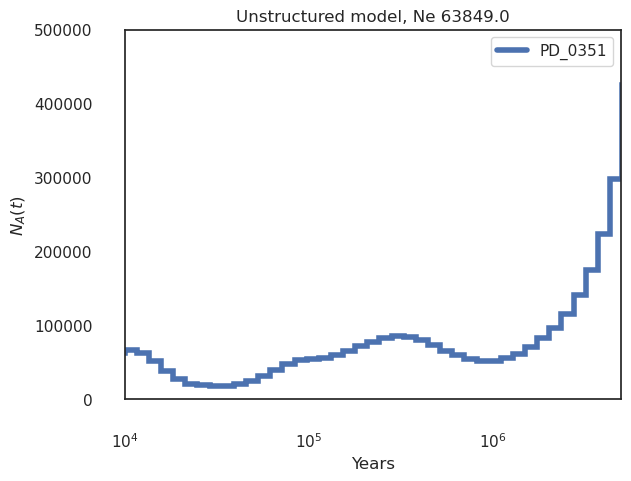

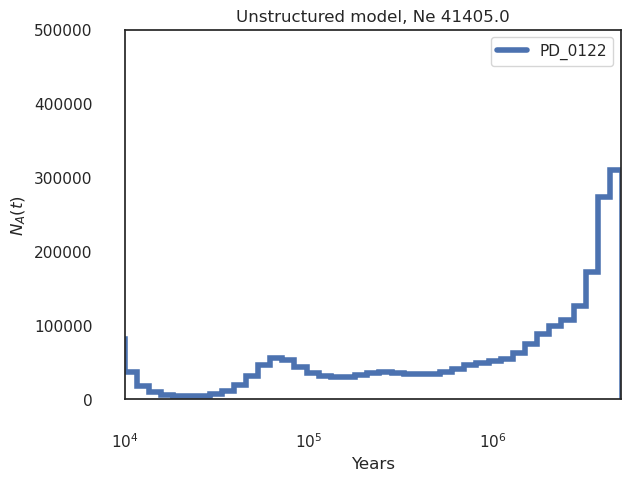

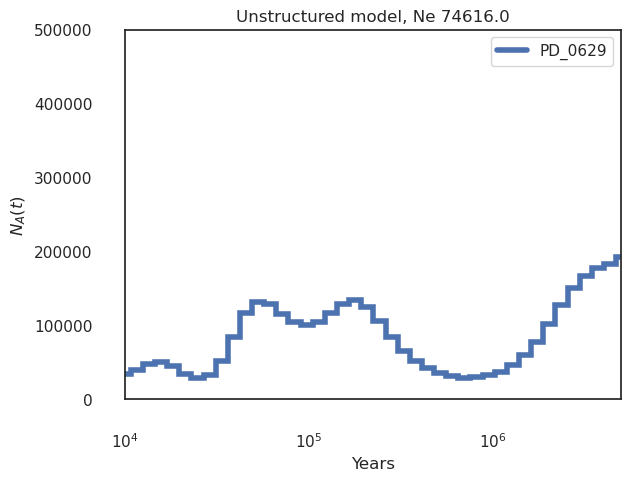

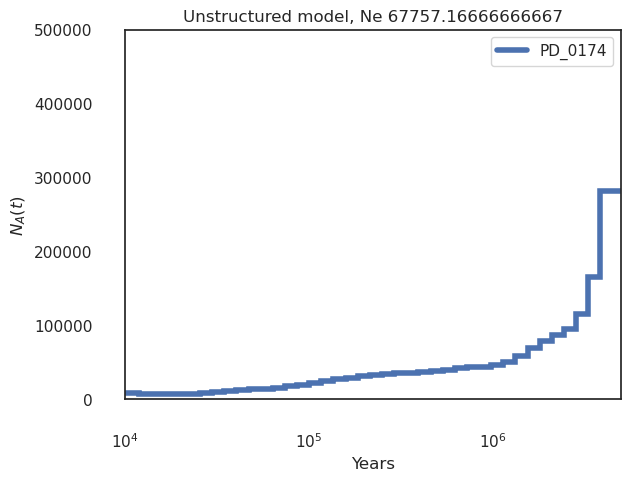

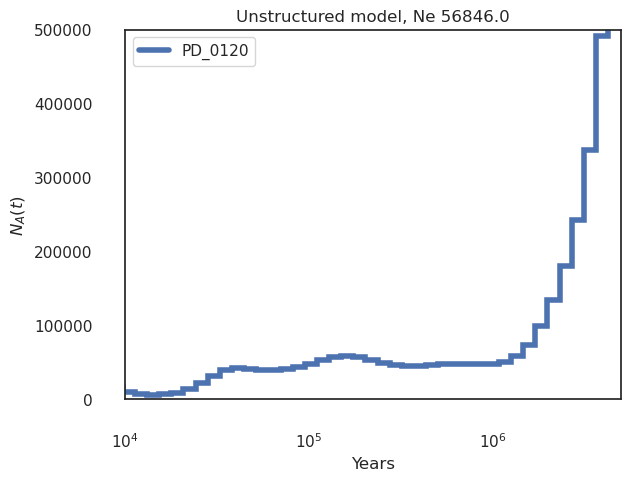

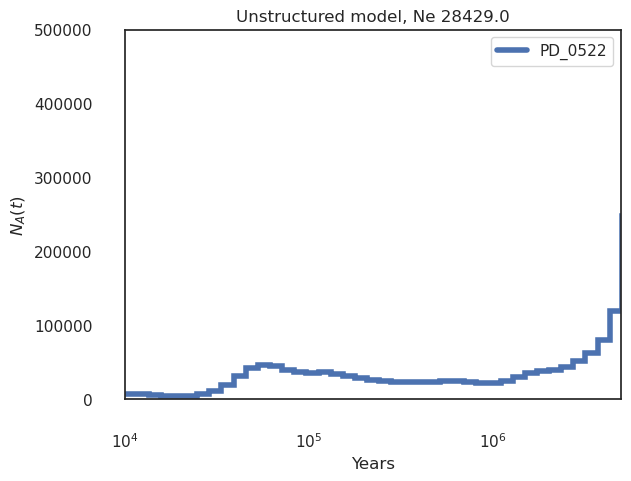

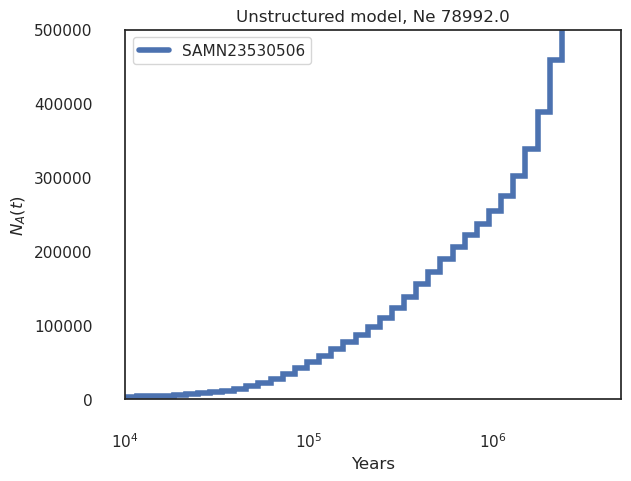

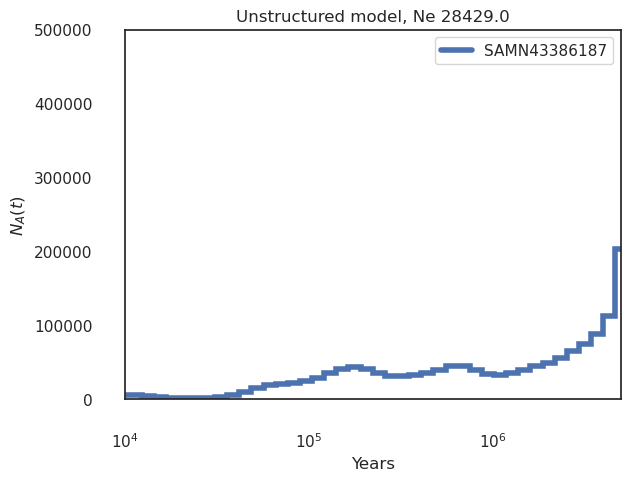

In [48]:
for p in c_list:
    label_tag = p.split("/")[-2]
    ind_inf = all_inds.loc[all_inds.GVCF_ID == label_tag]
    gs = ind_inf.GENUS.iloc[0]+"_"+ind_inf.SPECIES.iloc[0]
    gs_df = df_species_mut.loc[df_species_mut.SPECIES_BINOMIAL == gs]
    g_df = df_species_mut.loc[df_species_mut.GENUS == ind_inf.GENUS.iloc[0]] 
    if len(gs_df) > 0:
        mu = gs_df.MU_PER_GENERATION.mean()
        gen = gs_df.GENERATION_LENGTH.mean()
        kuderna_Ne = gs_df.EFFECTIVE_POP_SIZE.mean()
    elif len(g_df) > 0:
        mu = g_df.MU_PER_GENERATION.mean()
        gen = g_df.GENERATION_LENGTH.mean()
        kuderna_Ne = g_df.EFFECTIVE_POP_SIZE.mean()
    else:
        print(gs)
        continue
    final_params_file = p
    final_params = np.loadtxt(final_params_file)
    time_array = list(final_params[:,1])
    time_array.insert(0,0)
    time_array = np.array(time_array)
    plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=label_tag,linewidth=4,linestyle="solid",baseline=None)
    plt.xlim(1e+04,5e+06)
    plt.ylim(0,50e+04)
    plt.xscale('log')
    plt.ylabel('$N_A(t)$')
    plt.xlabel('Years')
    plt.tick_params(which='major',length=20)
    plt.tick_params(which='minor',length=10)
    plt.legend(ncol=2)
    plt.title('Unstructured model, Ne {}'.format(kuderna_Ne))
    plt.show()

In [31]:
final_params_file

'../steps/multihetsep/SAMN23530509/NC_044976.1.txt'

In [23]:
ind_inf

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,SUBSPECIES,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y
2,SAMN23530509,SAMN23530509,SAMN23530509,SRS11219902,PRJNA785018,Lophocebus_aterrimus_ssp,Lophocebus_aterrimus_ssp,Papio_anubis_ssp,Lophocebus,aterrimus,ssp,M,M,37.216,0.985,18.992,0.962,29.815,0.924
